# Делала Карина Тарасьева

In [4]:
!pip install numpy==1.26.3
!pip install tbats
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.3 which is incompatible.


In [209]:
import warnings, itertools, math, os, json, pathlib
warnings.filterwarnings("ignore")

from tbats import TBATS
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from prophet import Prophet
import lightgbm as lgb
from tqdm.auto import tqdm

In [210]:
CSV_PATH  = '/content/series.csv'
HORIZON   = 23
VAL_SIZE  = HORIZON

df = pd.read_csv(CSV_PATH, sep=',', skipinitialspace=True)

# определяем колонки даты и y:
date_cols = [c for c in df.columns if 'date' in c.lower() or c.lower().startswith('ds')]
y_cols    = [c for c in df.columns if c not in date_cols]
if date_cols:
    date_col = date_cols[0]
else:
    date_col = df.columns[0]
# выбираем первую не-date колонку числовую
y_col = [c for c in y_cols if c != date_col][0]

dates = df[date_col].astype(str)
if dates.str.match(r'^\d{6}$').all():
    df[date_col] = pd.to_datetime(dates, format='%y%m%d', errors='coerce')
elif dates.str.match(r'^\d{1,2}\.\d{1,2}\.\d{4}$').all():
    df[date_col] = pd.to_datetime(dates, format='%d.%m.%Y', dayfirst=True, errors='coerce')
else:
    df[date_col] = pd.to_datetime(dates, errors='coerce')
bad = df[date_col].isna().sum()
if bad:
    print(f" {bad} не распознано в колонке '{date_col}'")

# приводим y к float
df[y_col] = pd.to_numeric(df[y_col], errors='coerce')

series = (
    df[[date_col, y_col]]
      .dropna()
      .drop_duplicates(subset=[date_col], keep='first')  # убираем дубли во входных данных
      .set_index(date_col)[y_col]
)

print(series.head())
print('Частота (inferred):', series.index.inferred_freq)

date
2022-01-03    346.13
2022-01-10    335.76
2022-01-17    311.60
2022-01-24    329.58
2022-01-31    324.60
Name: PRICE, dtype: float64
Частота (inferred): None


In [211]:
series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 154 entries, 2022-01-03 to 2024-12-30
Series name: PRICE
Non-Null Count  Dtype  
--------------  -----  
154 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


In [212]:
train, val = series.iloc[:-VAL_SIZE], series.iloc[-VAL_SIZE:]

print(f"Train: {train.index[0]} … {train.index[-1]}  |  Val: {val.index[0]} … {val.index[-1]}")

Train: 2022-01-03 00:00:00 … 2024-07-22 00:00:00  |  Val: 2024-07-29 00:00:00 … 2024-12-30 00:00:00


In [213]:
def safe_forecast(model_name, fn):

    try:
        yhat = fn()
        mets = {
            'MAE' : mean_absolute_error(val, yhat),
            'RMSE': math.sqrt(mean_squared_error(val, yhat)),
            'MAPE': mean_absolute_percentage_error(val, yhat) * 100
        }
        return yhat, mets
    except Exception as e:
        print(f"[{model_name}] skipped ⇒ {e}")
        return None, None


In [214]:
from pandas.tseries.frequencies import to_offset

def _make_future_index(train_idx, steps):
    """Возвращает Index для прогноза длины steps, любого типа train_idx."""
    if isinstance(train_idx, pd.DatetimeIndex):
        freq = pd.infer_freq(train_idx)
        if freq is None and len(train_idx) > 1:
            # берём шаг между последними двумя точками
            freq = to_offset(train_idx[-1] - train_idx[-2])
        offset = to_offset(freq) if not isinstance(freq, pd.offsets.DateOffset) else freq
        return pd.date_range(start=train_idx[-1] + offset, periods=steps, freq=offset)
    else:

        return pd.RangeIndex(start=len(train_idx), stop=len(train_idx)+steps)

# ETS (Хольт-Уинтерс)
def ets_forecast(train, steps):
    best_aic, best_model = np.inf, None
    seasonal_periods = [None, 4, 7, 12, 24]
    for sp, t, s in itertools.product(seasonal_periods, ['add','mul'], ['add','mul',None]):
        try:
            m = ExponentialSmoothing(train, trend=t, seasonal=s, seasonal_periods=sp).fit(optimized=True)
            if m.aic < best_aic:
                best_aic, best_model = m.aic, m
        except: pass
    if best_model is None:
        raise RuntimeError("ETS: no model converged")
    idx_f = _make_future_index(train.index, steps)
    return pd.Series(best_model.forecast(steps), index=idx_f)

# SARIMA auto_arima
def sarima_forecast(train, steps):
    model = pm.auto_arima(train, seasonal=True, stepwise=True,
                          suppress_warnings=True, error_action='ignore')
    fc = model.predict(n_periods=steps)
    idx_f = _make_future_index(train.index, steps)
    return pd.Series(fc, index=idx_f)

# Prophet
def prophet_forecast(train, steps, X=None, freq_hint='D'):
    # 1) idx_train → ds
    if isinstance(train.index, pd.DatetimeIndex):
        idx = train.index
    else:
        start = pd.Timestamp.today().normalize()
        idx = pd.date_range(start, periods=len(train), freq=freq_hint)
    df_tr = pd.DataFrame({'ds': idx, 'y': train.values})
    if X is not None and not X.empty:
        df_tr = pd.concat([df_tr, X.reset_index(drop=True)], axis=1)
    m = Prophet()
    if X is not None and not X.empty:
        for c in X.columns: m.add_regressor(c)
    m.fit(df_tr.dropna())

    idx_f = _make_future_index(idx, steps)
    df_f = pd.DataFrame({'ds': idx_f})
    if X is not None and not X.empty:
        last_exog = X.iloc[[-1]]
        df_f = pd.concat([df_f, pd.DataFrame(np.repeat(last_exog.values, steps, axis=0),
                                              columns=X.columns)], axis=1)
    yhat = m.predict(df_f)['yhat'].values
    return pd.Series(yhat, index=idx_f)

# TBATS
def tbats_forecast(train, steps):
    estimator = TBATS(use_arma_errors=False, n_jobs=1)
    model = estimator.fit(train)
    fc = model.forecast(steps)
    idx_f = _make_future_index(train.index, steps)
    return pd.Series(fc, index=idx_f)

# LightGBM по лагам
def lgbm_forecast(train, steps, lags=(1,2,3,4,6,8,12,24,48)):
    def make_feats(y):
        df = pd.DataFrame({'y': y})
        for l in lags:
            df[f'lag_{l}'] = y.shift(l)
        return df.dropna()

    feats = make_feats(train)
    X_tr, y_tr = feats.drop(columns='y'), feats['y']    # <— так!
    model = lgb.LGBMRegressor(
        n_estimators=200,
        learning_rate=0.08,
        subsample=0.9,
        min_data_in_leaf=2,
        objective='regression_l1',
        verbosity=-1
    )
    model.fit(X_tr, y_tr)

    history = train.copy()
    preds = []
    for _ in range(steps):
        feat = make_feats(history).iloc[-1].drop(labels='y')
        yhat = model.predict(feat.values.reshape(1, -1))[0]
        preds.append(yhat)
        history = pd.concat([history, pd.Series([yhat], index=[_make_future_index(history.index,1)[0]])])

    idx_f = _make_future_index(train.index, steps)
    return pd.Series(preds, index=idx_f)


# Делал Даниил Гареев

In [201]:
models = {
    'ETS'     : lambda: ets_forecast(train, VAL_SIZE),
    'SARIMA'  : lambda: sarima_forecast(train, VAL_SIZE),
    'Prophet' : lambda: prophet_forecast(train, VAL_SIZE),
    'TBATS'   : lambda: tbats_forecast(train, VAL_SIZE),
    'LGBM'    : lambda: lgbm_forecast(train, VAL_SIZE),
}

results, metrics_table = {}, {}
for name, fn in tqdm(models.items(), desc="Training & forecasting"):
    yhat, mets = safe_forecast(name, fn)
    if yhat is not None:
        results[name]       = yhat
        metrics_table[name] = mets

metrics_df = (pd.DataFrame(metrics_table).T
              .sort_values('MAPE')
              .style.format('{:.3f}'))
metrics_df

Training & forecasting:   0%|          | 0/5 [00:00<?, ?it/s]

[ETS] skipped ⇒ Input contains NaN.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpft9r0x_e/88d1jdjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpft9r0x_e/ru9ui07o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16847', 'data', 'file=/tmp/tmpft9r0x_e/88d1jdjf.json', 'init=/tmp/tmpft9r0x_e/ru9ui07o.json', 'output', 'file=/tmp/tmpft9r0x_e/prophet_modeltnwuo3bm/prophet_model-20250610161841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[SARIMA] skipped ⇒ Input contains NaN.


,MAE,RMSE,MAPE
LGBM,6.727,7.676,5.319
TBATS,7.384,8.035,5.873
Prophet,14.925,21.210,12.221


In [215]:
"""
Стратегия: берём ТРИ лучших по MAPE модели,
усредняем c эмпирическими весами 40 % / 40 % / 20 %
"""
TOP_N = 3
weights = [0.4, 0.4, 0.2]

top_models = metrics_df.data.index[:TOP_N].tolist()
print("Blending models:", top_models)

AttributeError: 'DataFrame' object has no attribute 'data'

In [204]:
blend_val = sum(w * results[m] for w, m in zip(weights, top_models))

blend_metrics = {
    'MAE' : mean_absolute_error(val, blend_val),
    'RMSE': math.sqrt(mean_squared_error(val, blend_val)),
    'MAPE': mape(val, blend_val)*100
}
print("Blend metrics:", {k:f'{v:.3f}' for k,v in blend_metrics.items()})

# добавляем в таблицу для сравнения
metrics_df = (pd.concat([metrics_df.data,
                         pd.DataFrame({'Blend':blend_metrics}).T])
              .sort_values('MAPE'))
metrics_df.style.format('{:.3f}')

Blend metrics: {'MAE': '7.496', 'RMSE': '8.817', 'MAPE': '6.061'}


,MAE,RMSE,MAPE
LGBM,6.727,7.676,5.319
TBATS,7.384,8.035,5.873
Blend,7.496,8.817,6.061
Prophet,14.925,21.210,12.221


In [205]:
BEST = metrics_df.index[0]
print(f"Лучший вариант: {BEST}")

# переобучаем выбранные (или все, если блендинг)
def refit_predict_full(model_name, steps):
    if model_name == 'ETS':
        return ets_forecast(series, steps)
    if model_name == 'SARIMA':
        return sarima_forecast(series, steps)
    if model_name == 'Prophet':
        return prophet_forecast(series, steps)
    if model_name == 'TBATS':
        return tbats_forecast(series, steps)
    if model_name == 'LGBM':
        return lgbm_forecast(series, steps)
    if model_name == 'Blend':
        # строим все топ-модели на full-train и блендим
        full_preds = [refit_predict_full(m, steps) for m in top_models]
        return sum(w*p for w,p in zip(weights, full_preds))
    raise ValueError(model_name)

final_forecast = refit_predict_full(BEST, HORIZON)

Лучший вариант для отправки: LGBM


In [206]:
final_forecast

,0
2025-01-06,128.662443
2025-01-13,124.635752
2025-01-20,129.465221
2025-01-27,127.876774
2025-02-03,130.986460
2025-02-10,128.985932
2025-02-17,128.192995
2025-02-24,128.326529
2025-03-03,128.574101
2025-03-10,127.503549


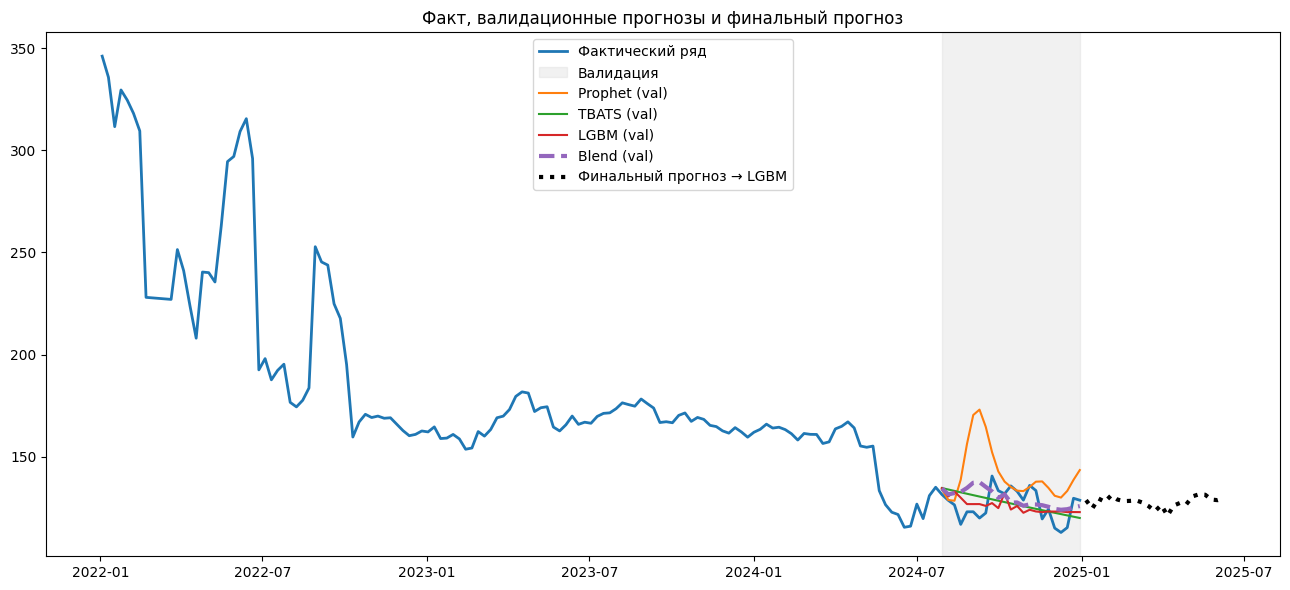

In [207]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,6))

# фактический ряд
plt.plot(series, label='Фактический ряд', lw=2)

# выделяем валидацию
plt.axvspan(val.index[0], val.index[-1],
            color='lightgray', alpha=0.3, label='Валидация')

# модели на val
for name, yhat in results.items():
    plt.plot(yhat.index, yhat, label=f'{name} (val)')

# blended‑на val
if 'blend_val' in globals():
    plt.plot(blend_val.index, blend_val,
             '--', lw=3, label='Blend (val)')

# финальный прогноз (после валидации) — BEST или Blend
plt.plot(final_forecast.index, final_forecast,
         color='black', linewidth=3, linestyle=':',
         label=f'Финальный прогноз → {BEST}')

plt.title('Факт, валидационные прогнозы и финальный прогноз')
plt.legend()
plt.tight_layout()
plt.show()

In [208]:
OUT_PATH = '/content/forecast.csv'
pd.Series(final_forecast.values, name='y').to_csv(OUT_PATH, index=False)
print(f"Файл сохранён: {OUT_PATH}")

✓ Файл сохранён: /content/forecast.csv
